In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sqlite3
import sqlalchemy as sa
from sqlalchemy.types import *


plt.style.use("fivethirtyeight")
plt.rc("figure", figsize=(20, 10))

In [238]:
engine = sa.create_engine('sqlite:///./database.db')

In [239]:
connection = engine.connect()

# Data preprocessing

Raw data is stored in **raw_data.csv**. Fields are separated with **@**. Because of the irregularity of web pages that were parsed, some lines might be completely broken. For the sake of simplicity I have saved only those lines containing all fields without missing values. Most of the popular titles are in, so that is not a big problem. Also data is raw, so it needs some preprocessing, mainly type conversions.

In [72]:
# It is seems like '@' was not the best separator, because it is present in nearly 20 titles
# "Bad lines" are lines containing @ in fields, they are ignored
data = pd.read_csv("raw_data.csv", sep="@", error_bad_lines=False, warn_bad_lines=False, na_values="None").dropna()
data.id = data.id.astype(int)                                      # Convert id to integer
data.score = data.score.astype(float)                              # Convert score to float
data.rating_count = data.rating_count.astype(int)                  # Convert rating_count to integer
data.rank = data["rank"].astype(int)                               # Convert rank to integer
data.popularity = data.popularity.astype(int)                      # Convert popularity to integer
data = data.drop(columns=["favorites"])                            # "favorites" is dropped due to parsing error
data.year = data.year.astype(int)                                  # Convert year to integer
data.episodes = data.episodes.where(data.episodes != "Unknown", 0)   # Convert "Unknown" number of episodes to 0 in order to maintain 1 type
data.genres = data.genres.apply(lambda x: x.split(","))            # Split genres into two columns with coarse and all genres
data["coarse_genre"] = data.genres.apply(lambda x: x[0])
data["all_genres"] = data.genres.apply(lambda x: " ".join(x))

coarse_genre_encoder = LabelEncoder().fit(data.coarse_genre)
all_genres_encoder = LabelEncoder().fit(data.all_genres)

data["coarse_genre_id"] = coarse_genre_encoder.transform(data.coarse_genre)
data["all_genres_id"] = all_genres_encoder.transform(data.all_genres)

data.studio = data.studio.where(lambda x: x != "add some")         # Ignore parsing error in "studio" field

# Database creation

Because it was very hard to distinguish any logically separated entities, final result may look a bit artifitial.

In [74]:
metadata = sa.schema.MetaData(bind=connection)   # Metadata object is used to bind Tables and Connection

In [75]:
anime_table = sa.Table("anime", metadata, sa.Column("id", INT(), sa.ForeignKey("descriptions.id"),
                                                    sa.ForeignKey("ranks.id"), primary_key=True, autoincrement=True),
                                          sa.Column("title_english", VARCHAR(100)),
                                          sa.Column("title_japanese", VARCHAR(100)))

description_table = sa.Table("descriptions", metadata, sa.Column("id", INT(), primary_key=True, autoincrement=True),
                                                       sa.Column("synopsys", TEXT(), nullable=True),
                                                       sa.Column("type", VARCHAR(10), nullable=True),
                                                       sa.Column("episodes", INT(), nullable=True),
                                                       sa.Column("rating", VARCHAR(10), nullable=True),
                                                       sa.Column("duration", VARCHAR(20), nullable=True),
                                                       sa.Column("season", VARCHAR(10), nullable=True),
                                                       sa.Column("year", INT(), nullable=True),
                                                       sa.Column("studio", VARCHAR(50), nullable=True),
                                                       sa.Column("coarse_genre_id", INT(),
                                                                 sa.ForeignKey("coarse_genres.id"),
                                                                 nullable=True),
                                                       sa.Column("all_genres_id", INT(),
                                                                 sa.ForeignKey("all_genres.id"),
                                                                 nullable=True))

ranks_table = sa.Table("ranks", metadata, sa.Column("id", INT(), sa.ForeignKey("anime.id"), primary_key=True, autoincrement=True),
                                          sa.Column("score", DECIMAL(4, 2)),
                                          sa.Column("rating_count", INT(), nullable=True),
                                          sa.Column("rank", INT(), nullable=True),
                                          sa.Column("popularity", INT(), nullable=True))

coarse_genre_table = sa.Table("coarse_genres", metadata, sa.Column("id", INT(), primary_key=True, autoincrement=True),
                                                         sa.Column("coarse_genre", VARCHAR(20), nullable=True))

all_genres_table = sa.Table("all_genres", metadata, sa.Column("id", INT(), primary_key=True, autoincrement=True),
                                                    sa.Column("all_genres", TEXT(), nullable=True))

In [76]:
# Tables creation
anime_table.create(checkfirst=True)
description_table.create(checkfirst=True)
ranks_table.create(checkfirst=True)
coarse_genre_table.create(checkfirst=True)
all_genres_table.create(checkfirst=True)

Fillings of different tables are separated in order to minimize possible error impact

In [77]:
with connection.begin(): # Create "anime" table 
    for _, row in data.loc[:, ["id", "title_english", "title_japanese"]].iterrows():
        connection.execute(anime_table.insert(), row.to_dict())

In [78]:
with connection.begin(): # Create "ranks" table 
    for _, row in data.loc[:, ["id", 'score', 'rating_count', 'rank', 'popularity']].iterrows():
        connection.execute(ranks_table.insert(), row.to_dict())

In [79]:
with connection.begin(): # Create "descriptions" table 
    for _, row in data.loc[:, ["id", "synopsys", "type", "episodes", "rating",
                               "duration", "season", "year", "studio",
                               "coarse_genre_id", "all_genres_id"]].iterrows():
        connection.execute(description_table.insert(), row.to_dict())

In [80]:
with connection.begin(): # Create "coarse_genres" table 
    for id_, genre in enumerate(coarse_genre_encoder.classes_):
        connection.execute(coarse_genre_table.insert(), {"id": id_, "coarse_genre": genre})

In [81]:
with connection.begin(): # Create "all_genres" table 
    for id_, genre in enumerate(all_genres_encoder.classes_):
        connection.execute(all_genres_table.insert(), {"id": id_, "all_genres": genre})

# Examples of requests and small EDA

**Select 1st element of *anime* table**

In [240]:
connection.execute("SELECT * FROM anime").fetchone()

(1, 'Cowboy Bebop', 'カウボーイビバップ')

**Select 1st element of *anime* table with description**

In [241]:
QUERY = """
SELECT title_english, year, episodes, duration FROM anime
JOIN descriptions ON anime.id = descriptions.id"""
pd.DataFrame.from_records(connection.execute(QUERY).fetchmany(5),
                          columns=["title_english", "year", "episodes", "duration"])

,title_english,year,episodes,duration
0,Cowboy Bebop,1998,26,24 min. per ep.
1,Trigun,1998,26,24 min. per ep.
2,Witch Hunter Robin,2002,26,25 min. per ep.
3,Bouken Ou Beet,2004,52,23 min. per ep.
4,Eyeshield 21,2005,145,23 min. per ep.


**Select first five elements with information about year, episodes and genres**

In [131]:
QUERY = """
SELECT title_english, year, episodes, duration, coarse_genre, all_genres FROM anime
JOIN descriptions ON anime.id = descriptions.id
JOIN coarse_genres ON descriptions.coarse_genre_id = coarse_genres.id
JOIN all_genres ON descriptions.all_genres_id = all_genres.id
"""
pd.DataFrame.from_records(connection.execute(QUERY).fetchmany(5),
                          columns=["title_english", "year", "episodes", "duration", "coarse_genre", "all_genres"])

,title_english,year,episodes,duration,coarse_genre,all_genres
0,Cowboy Bebop,1998,26,24 min. per ep.,Action,Action Adventure Comedy Drama Sci-Fi Space
1,Trigun,1998,26,24 min. per ep.,Action,Action Sci-Fi Adventure Comedy Drama Shounen
2,Witch Hunter Robin,2002,26,25 min. per ep.,Action,Action Mystery Police Supernatural Drama Magic
3,Bouken Ou Beet,2004,52,23 min. per ep.,Adventure,Adventure Fantasy Shounen Supernatural
4,Eyeshield 21,2005,145,23 min. per ep.,Action,Action Sports Comedy Shounen


**Select top 5 anime of all time (excluding those that were dropped during preprocessing)**

In [130]:
QUERY = """
SELECT title_english, year, score, rank, coarse_genre, all_genres FROM anime
JOIN descriptions ON anime.id = descriptions.id
JOIN coarse_genres ON descriptions.coarse_genre_id = coarse_genres.id
JOIN all_genres ON descriptions.all_genres_id = all_genres.id
JOIN ranks ON anime.id = ranks.id
ORDER BY rank
"""
pd.DataFrame.from_records(connection.execute(QUERY).fetchmany(5),
                          columns=["title_english", "year", "score", "rank", "coarse_genre", "all_genres"])

,title_english,year,score,rank,coarse_genre,all_genres
0,Fullmetal Alchemist: Brotherhood,2009,9.17,1,Action,Action Military Adventure Comedy Drama Magic F...
1,Steins;Gate,2011,9.11,3,Sci-Fi,Sci-Fi Psychological Drama Thriller
2,Gintama°,2015,9.09,4,Action,Action Comedy Historical Parody Samurai Sci-Fi...
3,Hunter x Hunter (2011),2011,9.08,5,Action,Action Adventure Fantasy Shounen Super Power
4,Shingeki no Kyojin: The Final Season,2021,9.02,9,Action,Action Military Mystery Super Power Drama Fant...


**Select 5 anime with the lowest score**

In [129]:
QUERY = """
SELECT title_english, year, score, rank, coarse_genre, all_genres FROM anime
JOIN descriptions ON anime.id = descriptions.id
JOIN coarse_genres ON descriptions.coarse_genre_id = coarse_genres.id
JOIN all_genres ON descriptions.all_genres_id = all_genres.id
JOIN ranks ON anime.id = ranks.id
ORDER BY score ASC
"""
pd.DataFrame.from_records(connection.execute(QUERY).fetchmany(5),
                          columns=["title_english", "year", "score", "rank", "coarse_genre", "all_genres"])

,title_english,year,score,rank,coarse_genre,all_genres
0,Ex-Arm,2021,2.97,11391,Action,Action Ecchi Sci-Fi Seinen
1,Vampire Holmes,2015,3.36,11371,Mystery,Mystery Comedy Supernatural
2,Forest Fairy Five,2017,3.38,11371,Music,Music Comedy Fantasy
3,Ladyspo,2018,3.41,11369,Action,Action Comedy Sci-Fi
4,Gibiate,2020,3.84,11348,Action,Action Horror Martial Arts Samurai Fantasy


**Select 5 most popular anime**

In [128]:
QUERY = """
SELECT title_english, year, score, popularity FROM anime
JOIN descriptions ON anime.id = descriptions.id
JOIN coarse_genres ON descriptions.coarse_genre_id = coarse_genres.id
JOIN all_genres ON descriptions.all_genres_id = all_genres.id
JOIN ranks ON anime.id = ranks.id
ORDER BY popularity ASC
"""
pd.DataFrame.from_records(connection.execute(QUERY).fetchmany(5),
                          columns=["title_english", "year", "score", "popularity"])

,title_english,year,score,popularity
0,Death Note,2006,8.63,1
1,Shingeki no Kyojin,2013,8.50,2
2,Fullmetal Alchemist: Brotherhood,2009,9.17,3
3,Sword Art Online,2012,7.22,4
4,One Punch Man,2015,8.55,5


**Select anime with the highest score for each year**

In [138]:
QUERY = """
SELECT title_english, MAX(score), year FROM anime
JOIN descriptions ON anime.id = descriptions.id
JOIN coarse_genres ON descriptions.coarse_genre_id = coarse_genres.id
JOIN all_genres ON descriptions.all_genres_id = all_genres.id
JOIN ranks ON anime.id = ranks.id
GROUP BY year
"""
data = pd.DataFrame.from_records(connection.execute(QUERY).fetchall(),
                                 columns=["title_english", "score", "year"])
data

,title_english,score,year
0,Tetsuwan Atom,7.10,1963
1,Yuusei Shounen Papii,5.78,1965
2,Osomatsu-kun,6.45,1966
3,Mach GoGoGo,6.65,1967
4,Gegege no Kitarou (1968),6.77,1968
5,Tiger Mask,7.26,1969
6,Ashita no Joe,8.28,1970
7,Lupin III,7.66,1971
8,Seigi wo Aisuru Mono Gekkou Kamen,6.62,1972
9,Mazinger Z,7.27,1973


<AxesSubplot:xlabel='year', ylabel='score'>

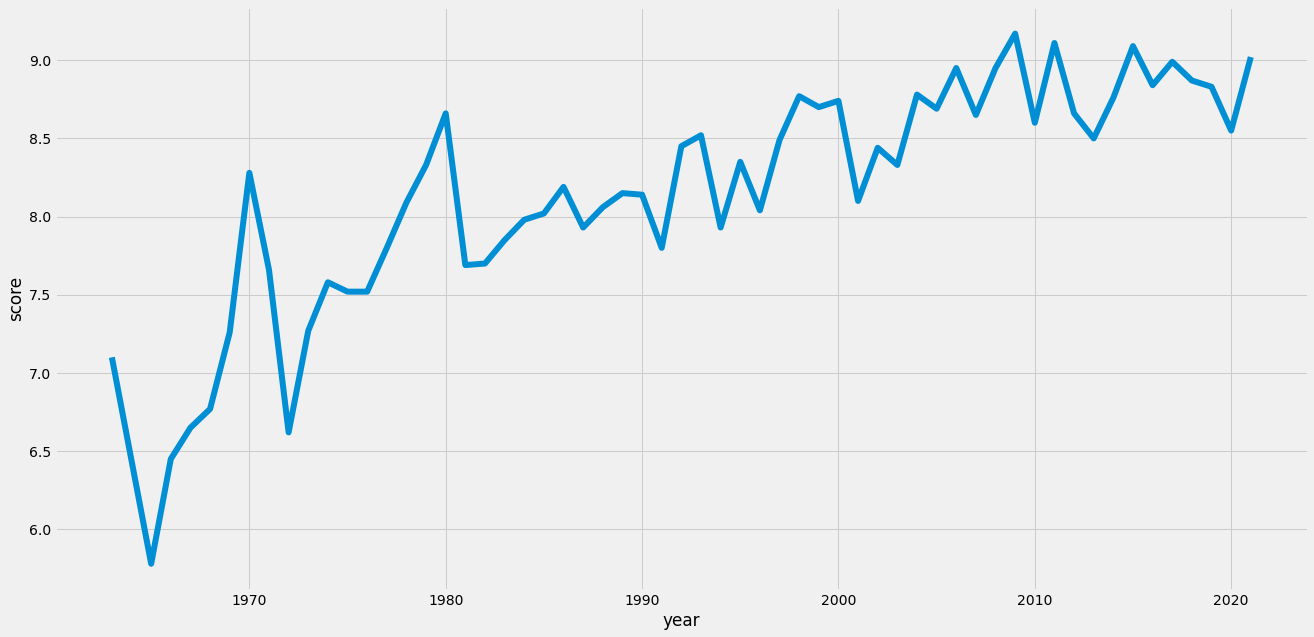

In [125]:
sns.lineplot(x="year", y="score", data=data, lw=6)

The maximum score of anime is constantly increasing.

**Select average, maximum and minimum score for each year**

<AxesSubplot:xlabel='year', ylabel='max'>

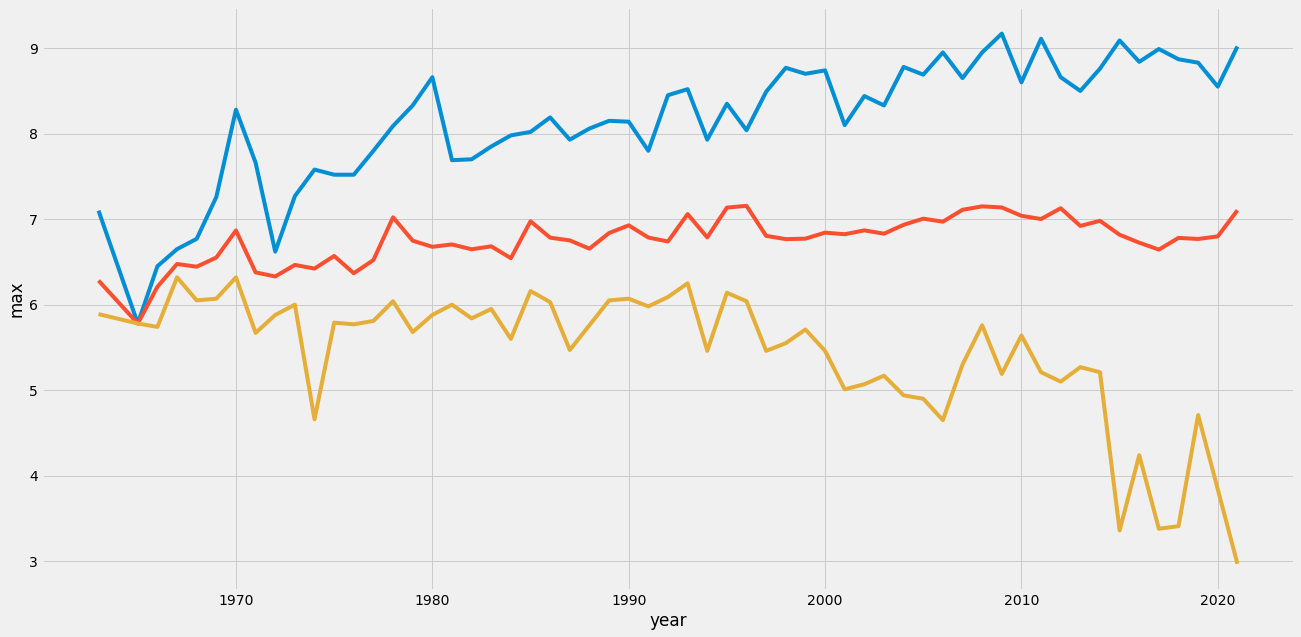

In [148]:
QUERY = """
SELECT AVG(score), MAX(score), MIN(score), year FROM descriptions
JOIN ranks ON descriptions.id = ranks.id
GROUP BY year
"""
data = pd.DataFrame.from_records(connection.execute(QUERY).fetchall(),
                                 columns=["avg", "max", "min", "year"])
sns.lineplot(x="year", y="max", data=data)
sns.lineplot(x="year", y="avg", data=data)
sns.lineplot(x="year", y="min", data=data)

It is funny that average score increased just a bit since 1960 year, however minimum score decreased dramatically. This may happen due to higher number of animes in the last time, we simply have higher chance of getting bad shows.

**Number of anime over time**

In [149]:
QUERY = """
SELECT COUNT(title_english), year FROM anime
JOIN descriptions ON anime.id = descriptions.id
GROUP BY year
"""
data = pd.DataFrame.from_records(connection.execute(QUERY).fetchall(),
                                 columns=["count", "year"])

<AxesSubplot:xlabel='year', ylabel='count'>

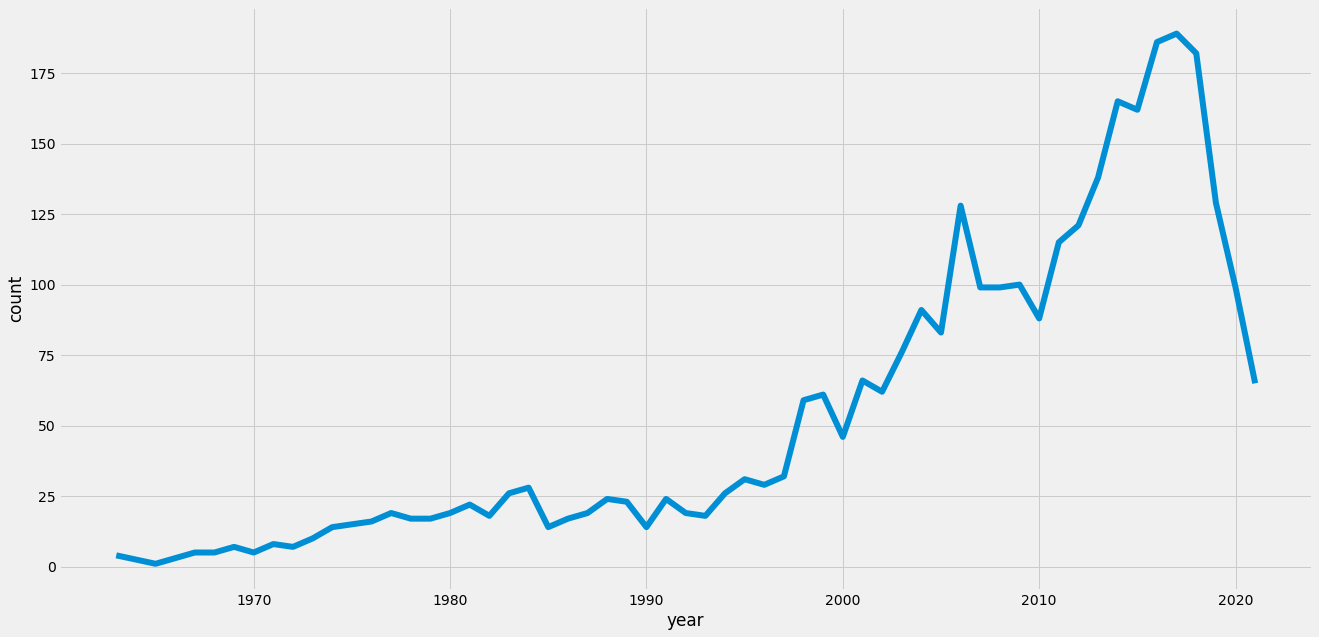

In [150]:
sns.lineplot(x="year", y="count", data=data, lw=6)

Number of anime is constantly increased until the 2010 year. Then it increased again, but dropped in year 2019. Probably this might happen because of pandemic.

**What is the most high rated genre?**

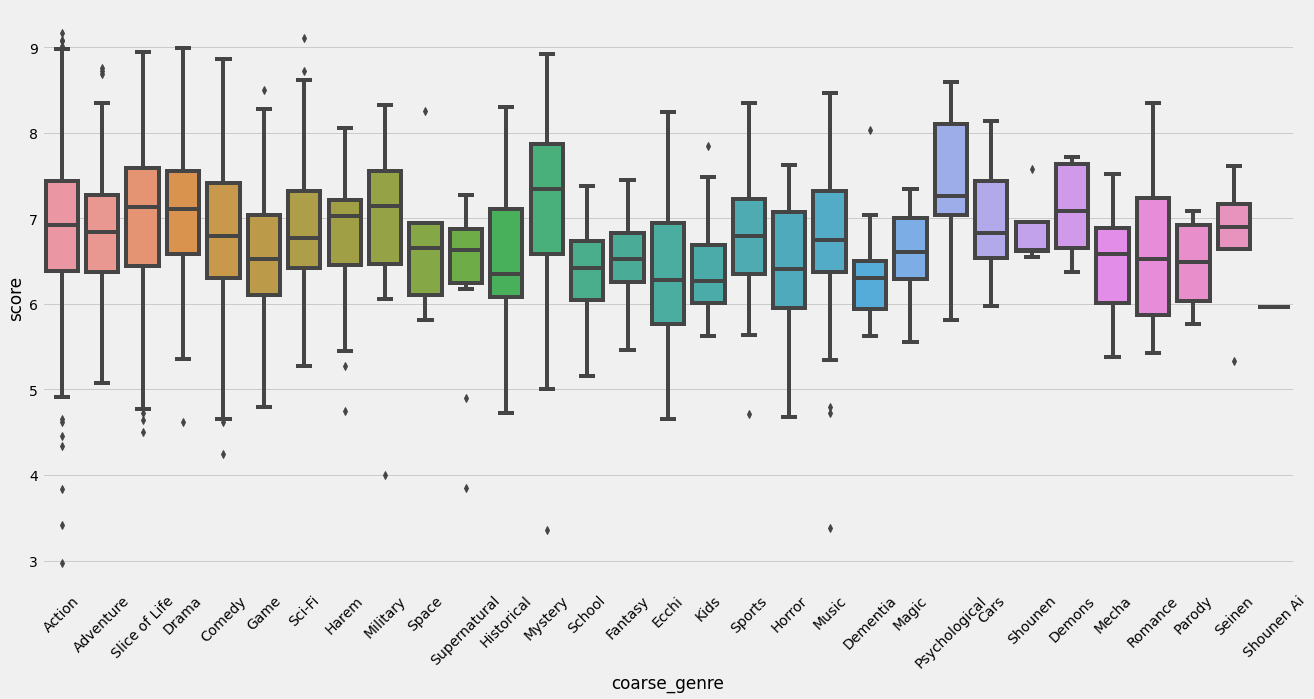

In [198]:
QUERY = """
SELECT score, coarse_genre FROM descriptions
JOIN coarse_genres ON descriptions.coarse_genre_id = coarse_genres.id
JOIN ranks ON descriptions.id = ranks.id
"""
data = pd.DataFrame.from_records(connection.execute(QUERY).fetchall(),
                                 columns=["score", "coarse_genre"])
sns.boxplot(x="coarse_genre", y="score", data=data)
_ = plt.xticks(rotation=45)

*Psychological* is seem to be the most high rated genre. Let's look on that.

In [173]:
QUERY = """
SELECT title_english, score, coarse_genre FROM anime
JOIN descriptions ON anime.id = descriptions.id
JOIN coarse_genres ON descriptions.coarse_genre_id = coarse_genres.id
JOIN ranks ON descriptions.id = ranks.id
WHERE coarse_genre = "Psychological"
ORDER BY score DESC
"""
data = pd.DataFrame.from_records(connection.execute(QUERY).fetchall(),
                                 columns=["title_english", "score", "coarse_genre"])
data

,title_english,score,coarse_genre
0,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Seas...,8.60,Psychological
1,Re:Zero kara Hajimeru Isekai Seikatsu 2nd Season,8.45,Psychological
2,Mahou Shoujo Madoka★Magica,8.37,Psychological
3,Re:Zero kara Hajimeru Isekai Seikatsu,8.28,Psychological
4,Ergo Proxy,7.92,Psychological
5,Youkoso Jitsuryoku Shijou Shugi no Kyoushitsu ...,7.84,Psychological
6,Oniisama e...,7.80,Psychological
7,Munou na Nana,7.26,Psychological
8,Boogiepop wa Warawanai,7.16,Psychological
9,Aku no Hana,7.15,Psychological


**What is the best studio?**

We will filter only those studios that have at least 3 titles. Studios with 1 or 2 titles may have great impact on results.

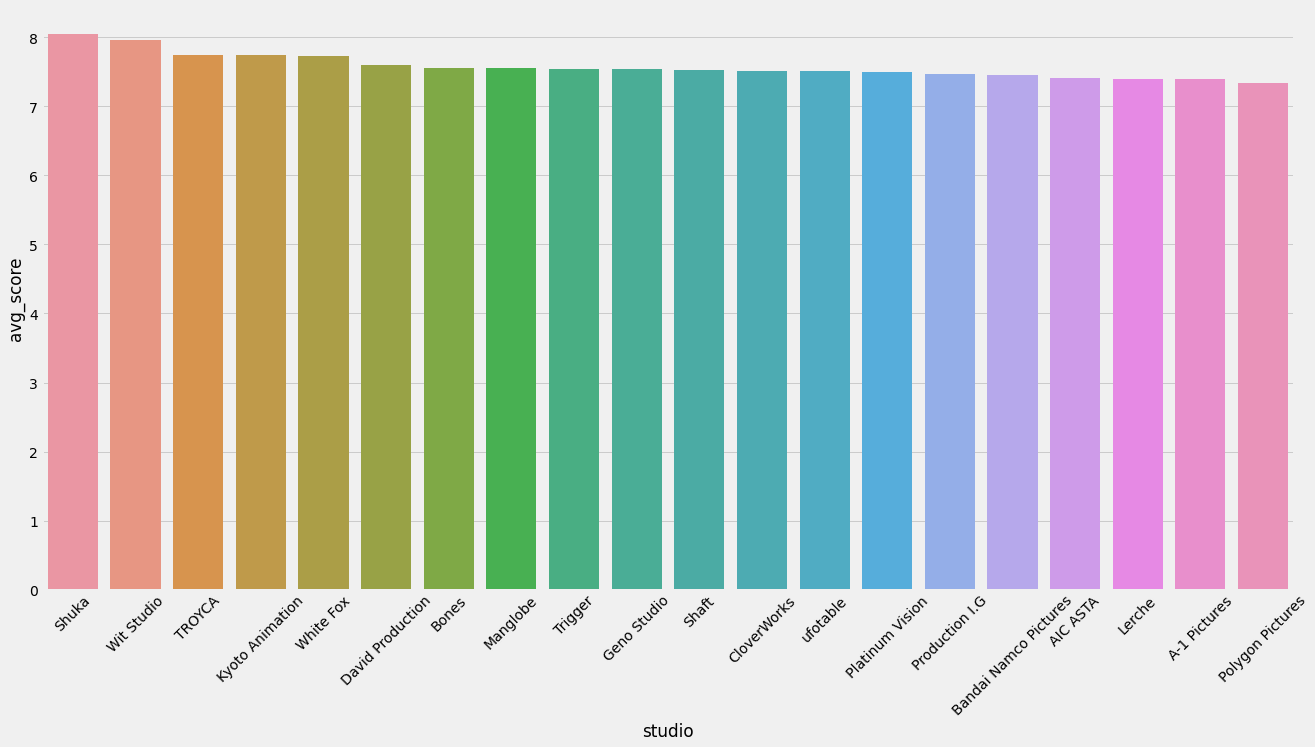

In [197]:
QUERY = """
SELECT * FROM
    (SELECT AVG(score) AS avg_s, studio, COUNT() AS cnt FROM descriptions
    JOIN ranks ON descriptions.id = ranks.id
    GROUP BY studio
    ORDER BY avg_s DESC)
WHERE cnt > 3
LIMIT 20
"""
data = pd.DataFrame.from_records(connection.execute(QUERY).fetchall(),
                                 columns=["avg_score", "studio", "count"])
sns.barplot(x="studio", y="avg_score", data=data)
_ = plt.xticks(rotation=45)

**Subset of particular franchise**

In [230]:
QUERY = """
SELECT title_english FROM anime
WHERE title_english LIKE "%pokemon%"
"""
data = pd.DataFrame.from_records(connection.execute(QUERY).fetchall(),
                                 columns=["title_english"])
data

,title_english
0,Pokemon
1,Pokemon Advanced Generation
2,Pokemon Diamond & Pearl
3,Pokemon Housoukyoku
4,Pokemon Best Wishes!
5,Pokemon Best Wishes! Season 2
6,Pokemon Best Wishes! Season 2: Episode N
7,Pokemon Best Wishes! Season 2: Decolora Adventure
8,Pokemon XY&Z
9,Pokemon Sun & Moon


**What is the most high rated age restriction rating?**

<AxesSubplot:xlabel='rating', ylabel='score'>

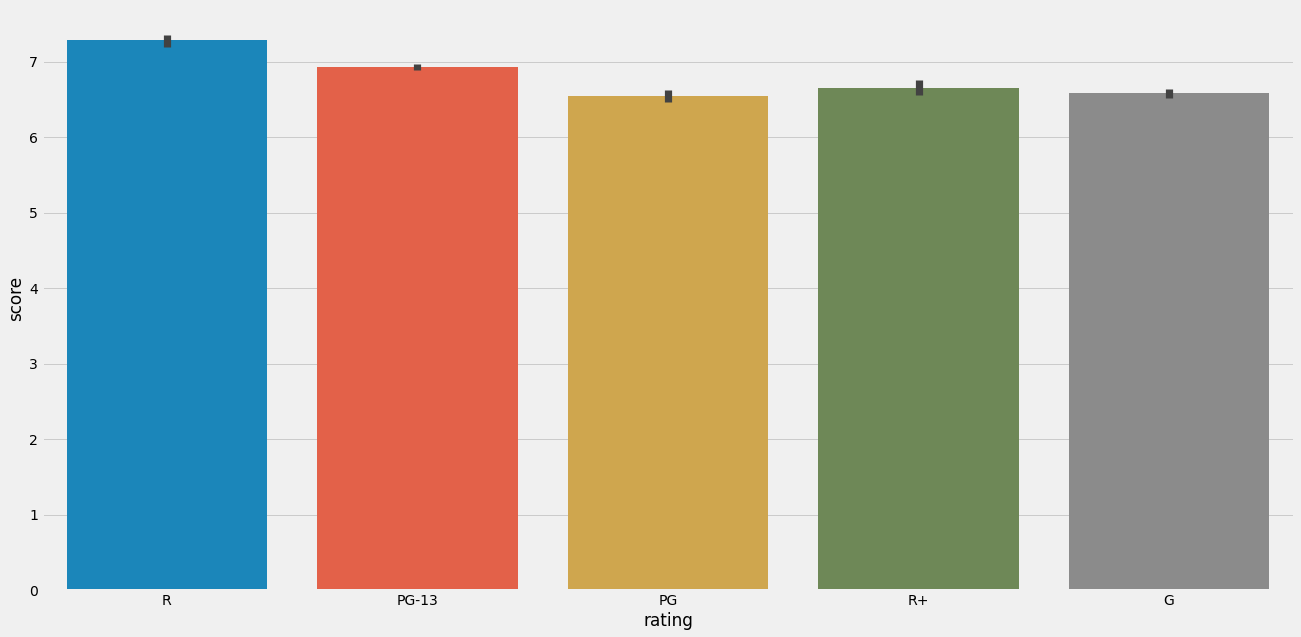

In [234]:
QUERY = """
SELECT score, rating FROM ranks
JOIN descriptions ON ranks.id = descriptions.id
"""
data = pd.DataFrame.from_records(connection.execute(QUERY).fetchall(),
                                 columns=["score", "rating"])
sns.barplot(x="rating", y="score", data=data)

In [73]:
# Removes all tables (DEBUG)
connection.execute("DROP TABLE anime")
connection.execute("DROP TABLE ranks")
connection.execute("DROP TABLE descriptions")
connection.execute("DROP TABLE coarse_genres")
connection.execute("DROP TABLE all_genres")

In [242]:
connection.close()